In [104]:
import pandas as pd
from datetime import datetime

weather_data_filepath = "data/weather_data.csv"
electricity_data_filepath = "data/electricity_production_data.csv"

df_weather = pd.read_csv(weather_data_filepath, delimiter=',')
df_electricity = pd.read_csv(electricity_data_filepath, delimiter=',')

df_weather['time'] = pd.to_datetime(df_weather['referenceTime'])
df_electricity['time'] = pd.to_datetime(df_electricity['måned'], format='%YM%m')
df_weather = df_weather.drop(columns="referenceTime")
df_electricity = df_electricity.drop(columns="måned")

df_weather['month_year'] = df_weather['time'].dt.strftime('%Y-%m')
df_electricity['month_year'] = df_electricity['time'].dt.strftime('%Y-%m')

df_weather['rolling_mean_precipitation'] = df_weather['value'].rolling(window=30).mean()
df_electricity['rolling_mean_electricity'] = df_electricity['value'].rolling(window=30).mean()

df_filtered_weather = df_weather[(df_weather['month_year'] >= df_electricity['month_year'].min()) & (df_weather['month_year'] <= df_electricity['month_year'].max())]
df_filtered_weather.reset_index(drop=True, inplace=True)

merged_df = pd.merge(df_filtered_weather, df_electricity, on='month_year', suffixes=('_precipitation', '_electricity'))

In [105]:
df_weather.head()

,value,time,month_year,rolling_mean_precipitation
0,16.5,1950-12-31 23:00:00+00:00,1950-12,NaN
1,7.9,1951-01-31 23:00:00+00:00,1951-01,NaN
2,36.8,1951-02-28 23:00:00+00:00,1951-02,NaN
3,35.4,1951-03-31 23:00:00+00:00,1951-03,NaN
4,29.0,1951-04-30 23:00:00+00:00,1951-04,NaN


In [106]:
merged_df.head()

,value_precipitation,time_precipitation,month_year,rolling_mean_precipitation,value_electricity,time_electricity,rolling_mean_electricity
0,96.6,1993-01-31 23:00:00+00:00,1993-01,71.210000,698737,1993-01-01,NaN
1,57.0,1993-02-28 23:00:00+00:00,1993-02,70.453333,654965,1993-02-01,NaN
2,21.2,1993-03-31 22:00:00+00:00,1993-03,68.986667,673560,1993-03-01,NaN
3,62.1,1993-04-30 22:00:00+00:00,1993-04,69.166667,488486,1993-04-01,NaN
4,61.5,1993-05-31 22:00:00+00:00,1993-05,68.816667,465860,1993-05-01,NaN


In [107]:
import statsmodels.tsa.stattools as ts

df_weather.reset_index(drop=True, inplace=True)
df_weather.set_index('month_year', inplace=True, drop=False)
df_electricity.reset_index(drop=True, inplace=True)
df_electricity.set_index('month_year', inplace=True, drop=False)
adf_result_electricity = ts.adfuller(df_electricity['value'])
adf_result_weather = ts.adfuller(df_weather['value'])


# Extract and display the test results
print("Electricity ADF:")
print('ADF Statistic:', adf_result_electricity[0])
print('p-value:', adf_result_electricity[1])
print('Critical Values:')
for key, value in adf_result_electricity[4].items():
    print(f'   {key}: {value}')

print("\n" +"Weather ADF:")
print('ADF Statistic:', adf_result_weather[0])
print('p-value:', adf_result_weather[1])
print('Critical Values:')
for key, value in adf_result_weather[4].items():
    print(f'   {key}: {value}')

Electricity ADF:
ADF Statistic: -5.292371473759111
p-value: 5.6784412662913794e-06
Critical Values:
   1%: -3.461429147102264
   5%: -2.875206950587861
   10%: -2.5740544497344002

Weather ADF:
ADF Statistic: -7.412360739804038
p-value: 7.079276075934034e-11
Critical Values:
   1%: -3.438489266223099
   5%: -2.8651325741144573
   10%: -2.5686830088234025


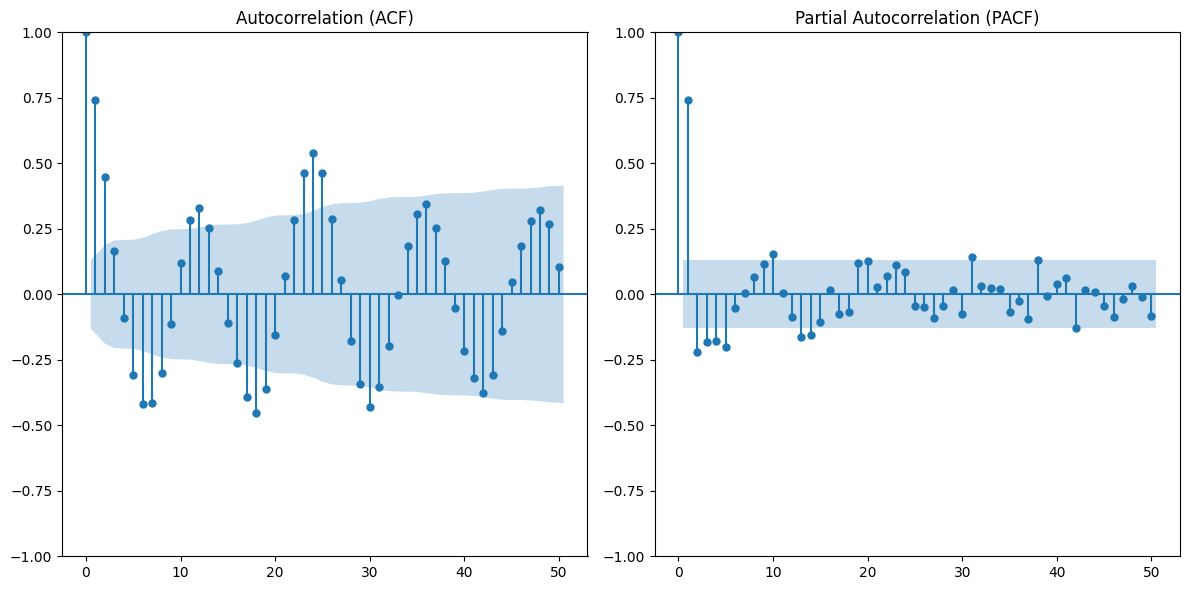

In [167]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plotting ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(df_electricity['value'], lags=50, ax=plt.gca())
plt.title("Autocorrelation (ACF)")

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(df_electricity['value'], lags=50, ax=plt.gca())
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()


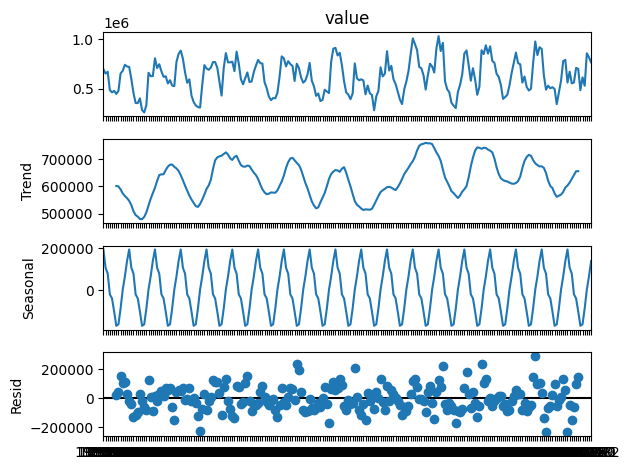

In [109]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_electricity['value'], model='additive', period=12)
decomposition.plot()
plt.show()

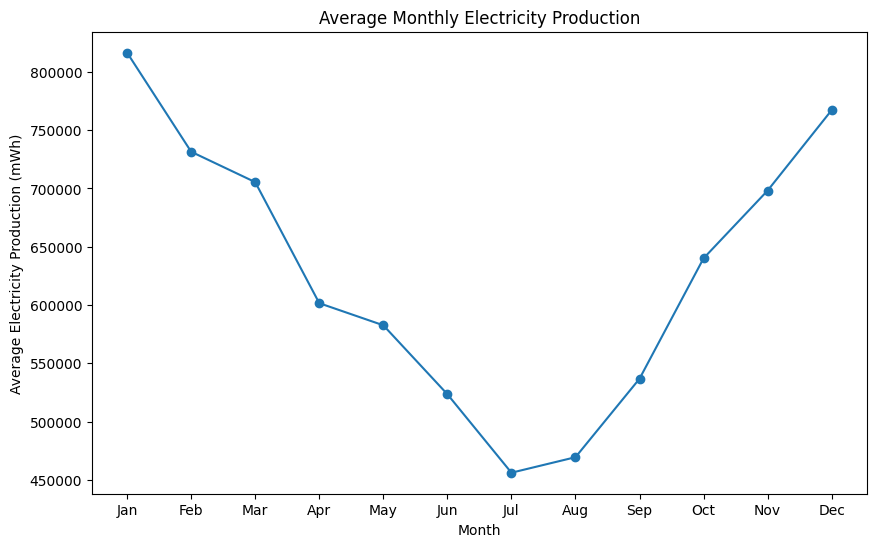

In [110]:
import matplotlib.pyplot as plt

df_electricity.index = pd.to_datetime(df_electricity.index, format="%Y-%m")
# Extract month and group by month to calculate the average for each month
monthly_avg = df_electricity.groupby(df_electricity.index.month)['value'].mean()

# Plot the monthly averages
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), monthly_avg, marker='o')
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Average Electricity Production (mWh)")
plt.title("Average Monthly Electricity Production")
plt.show()


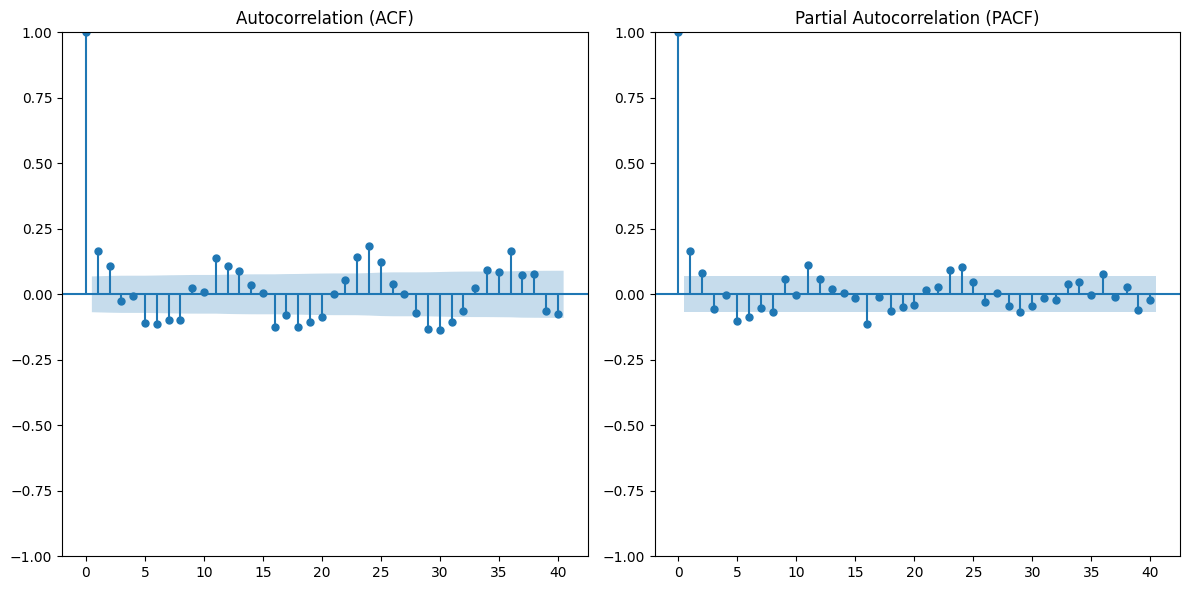

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plotting ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(df_weather['value'], lags=40, ax=plt.gca())
plt.title("Autocorrelation (ACF)")

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(df_weather['value'], lags=40, ax=plt.gca())
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()


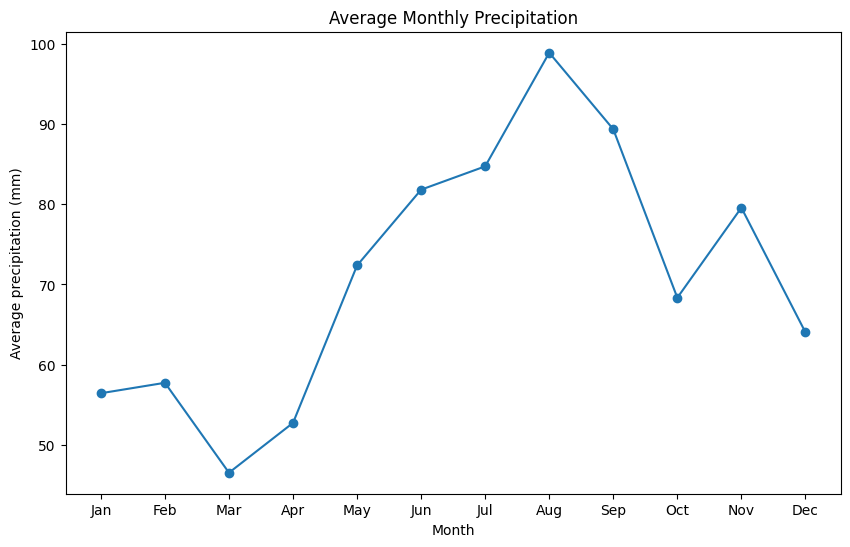

In [113]:
df_weather.index = pd.to_datetime(df_weather.index, format="%Y-%m")
# Extract month and group by month to calculate the average for each month
monthly_avg_weather = df_weather.groupby(df_weather.index.month)['value'].mean()

# Plot the monthly averages
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), monthly_avg_weather, marker='o')
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Average precipitation (mm)")
plt.title("Average Monthly Precipitation")
plt.show()


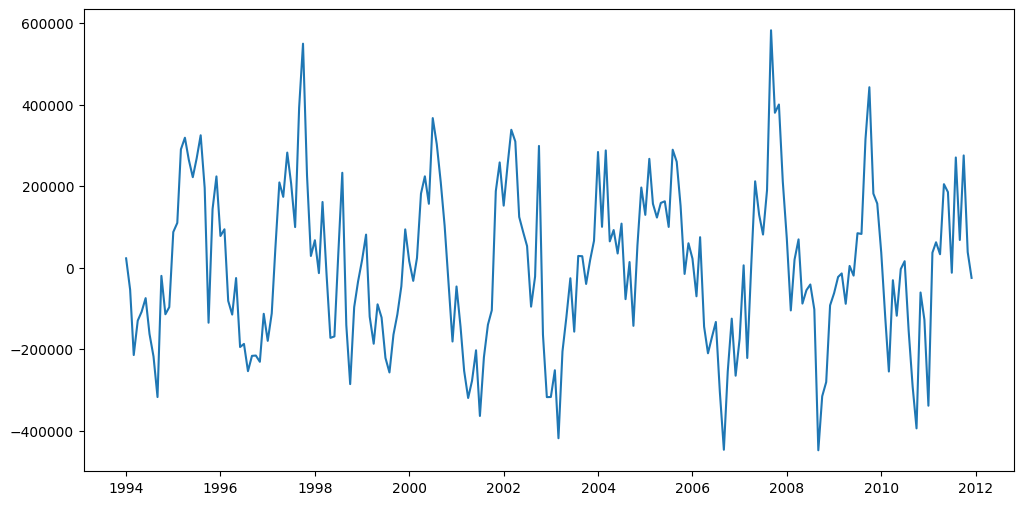

In [173]:
df_weather['value_diff'] = df_weather['value'].diff(12)
df_electricity['value_diff'] = df_electricity['value'].diff(12)

df_electricity.dropna()
df_weather.dropna()

plt.figure(figsize=(12,6))
plt.plot(df_electricity['value_diff'])

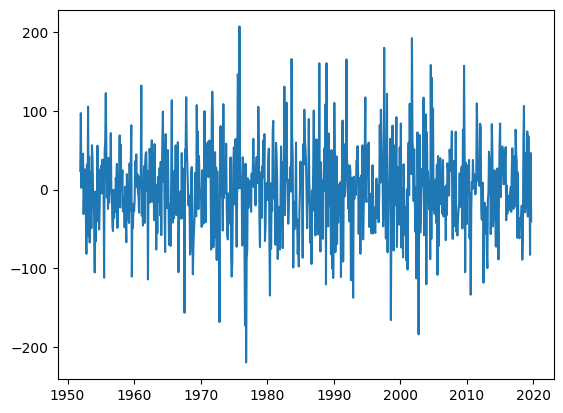

In [141]:
plt.plot(df_weather['value_diff'])

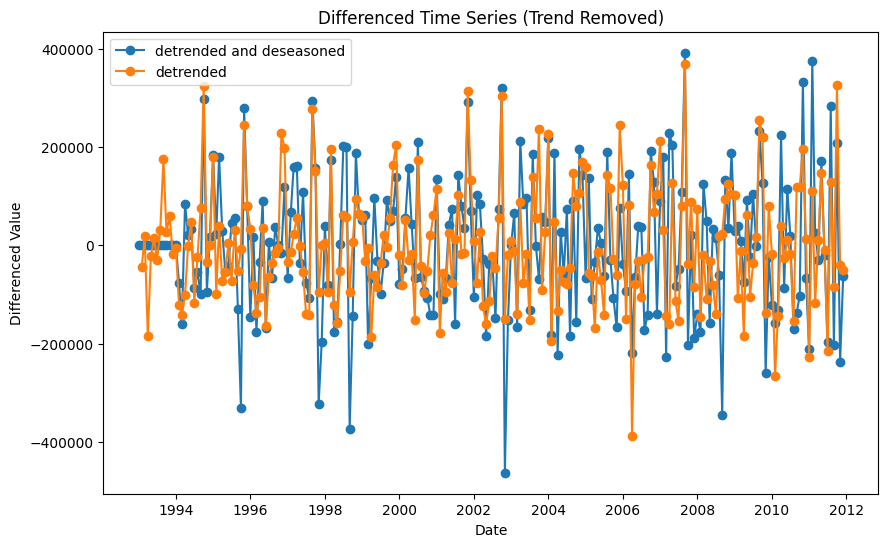

In [155]:
df_electricity['value_detrended'] = df_electricity['value'].diff().dropna()
differenced_deseasoned_data = df_electricity['value_detrended'].diff(12).fillna(0)
# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(differenced_deseasoned_data, marker='o', label="detrended and deseasoned")
plt.plot(df_electricity['value_detrended'], marker='o', label="detrended")
plt.xlabel("Date")
plt.ylabel("Differenced Value")
plt.title("Differenced Time Series (Trend Removed)")
plt.legend()
plt.show()

## Moving average detrending

In [157]:
df_electricity.tail()

,value,time,month_year,rolling_mean_electricity,value_diff,value_detrended
month_year,,,,,,
2011-08-01,617198,2011-08-01,2011-08,629282.533333,270210.0,129588.0
2011-09-01,532577,2011-09-01,2011-09,622086.933333,67839.0,-84621.0
2011-10-01,859058,2011-10-01,2011-10,631931.700000,275218.0,326481.0
2011-11-01,818176,2011-11-01,2011-11,638365.566667,38081.0,-40882.0
2011-12-01,767073,2011-12-01,2011-12,646577.833333,-25191.0,-51103.0


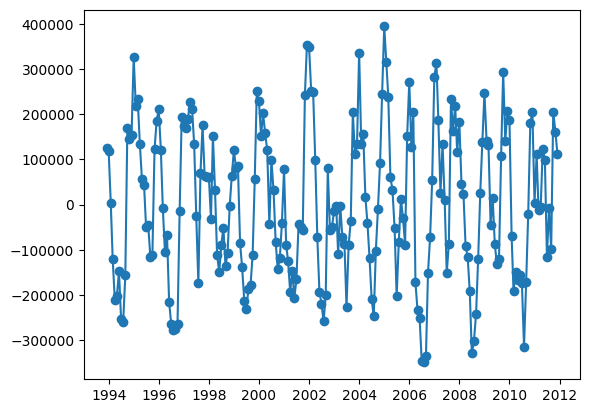

In [158]:
window_size = 12
moving_avg = df_electricity['value'].rolling(window=window_size).mean()

df_detrended_ma_electricity = df_electricity['value']-moving_avg
df_detrended_ma_electricity = df_detrended_ma_electricity.dropna()

plt.plot(df_detrended_ma_electricity, marker='o')

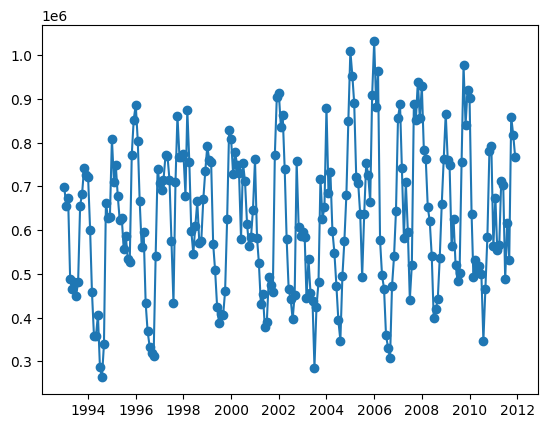

In [159]:
plt.plot(df_electricity['value'], marker='o')

## Linear regression detrending

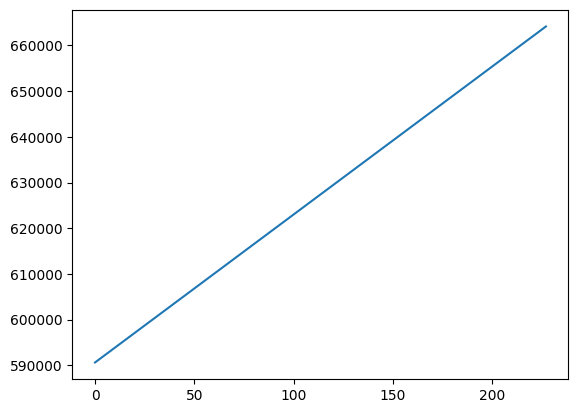

In [164]:
from sklearn.linear_model import LinearRegression
import numpy as np
df_electricity['arange_time'] = np.arange(len(df_electricity.index))
X = df_electricity[['arange_time']]
y = df_electricity['value']

model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)

plt.plot(trend)

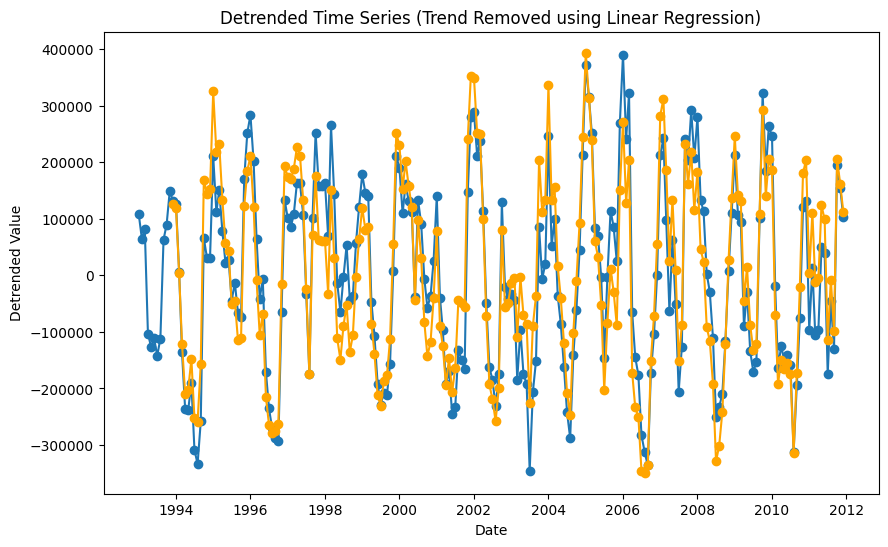

In [166]:
df_detrended_regression_electricity = df_electricity['value']-trend

plt.figure(figsize=(10, 6))
plt.plot(df_detrended_regression_electricity, marker='o')
plt.plot(df_detrended_ma_electricity, marker='o', color="orange")
plt.xlabel("Date")
plt.ylabel("Detrended Value")
plt.title("Detrended Time Series (Trend Removed using Linear Regression)")
plt.show()

### Weather data regression

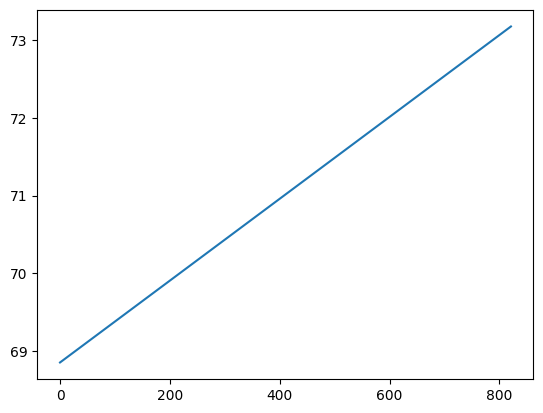

In [163]:
df_weather['arange_time'] = np.arange(len(df_weather.index))
X = df_weather[['arange_time']]
y = df_weather['value']

model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)

plt.plot(trend)